In [2]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score,
    recall_score, f1_score, confusion_matrix, RocCurveDisplay
)

# Reproducibility
RANDOM_STATE = 42
rng = np.random.default_rng(RANDOM_STATE)
random.seed(RANDOM_STATE)


In [3]:
# Try common Kaggle paths or fallback to working dir
def try_load_csv():
    candidates = [
        '/kaggle/input/heart-disease-dataset-uci/HeartDiseaseTrain-Test.csv',
        '/kaggle/input/heart-failure-prediction/heart.csv',
    ]
    for p in candidates:
        if os.path.exists(p):
            df = pd.read_csv(p)
            print(f"Loaded dataset from: {p} | shape={df.shape}")
            return df
    raise FileNotFoundError("Dataset not found! Upload heart.csv or attach Kaggle dataset.")

df = try_load_csv()
df.head()


Loaded dataset from: /kaggle/input/heart-disease-dataset-uci/HeartDiseaseTrain-Test.csv | shape=(1025, 14)


,age,sex,chest_pain_type,resting_blood_pressure,cholestoral,fasting_blood_sugar,rest_ecg,Max_heart_rate,exercise_induced_angina,oldpeak,slope,vessels_colored_by_flourosopy,thalassemia,target
0,52,Male,Typical angina,125,212,Lower than 120 mg/ml,ST-T wave abnormality,168,No,1.0,Downsloping,Two,Reversable Defect,0
1,53,Male,Typical angina,140,203,Greater than 120 mg/ml,Normal,155,Yes,3.1,Upsloping,Zero,Reversable Defect,0
2,70,Male,Typical angina,145,174,Lower than 120 mg/ml,ST-T wave abnormality,125,Yes,2.6,Upsloping,Zero,Reversable Defect,0
3,61,Male,Typical angina,148,203,Lower than 120 mg/ml,ST-T wave abnormality,161,No,0.0,Downsloping,One,Reversable Defect,0
4,62,Female,Typical angina,138,294,Greater than 120 mg/ml,ST-T wave abnormality,106,No,1.9,Flat,Three,Fixed Defect,0


In [4]:
from dataclasses import dataclass
from typing import List

# Config for the GA
@dataclass
class GAConfig:
    pop_size: int = 40         # population size
    generations: int = 30      # number of generations
    p_crossover: float = 0.9   # probability of crossover
    p_mutation: float = 0.05   # mutation probability (per bit)
    elitism_k: int = 2         # number of elites to carry over
    tournament_k: int = 3      # tournament size for selection
    min_features: int = 1      # minimum number of features required
    cv_splits: int = 5         # stratified k-fold CV

# Representation of a solution (feature mask)
@dataclass
class Individual:
    mask: np.ndarray  # boolean mask of selected features
    fitness: float = None

# Build pipeline
def make_pipeline():
    return Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=2000, solver="liblinear", random_state=RANDOM_STATE))
    ])

# Evaluate individual with CV ROC-AUC
def evaluate_mask(mask: np.ndarray, X: np.ndarray, y: np.ndarray, cv_splits: int) -> float:
    if mask.sum() == 0:  # no features selected
        return 0.5
    X_sel = X[:, mask]
    skf = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=RANDOM_STATE)
    aucs = []
    for train_idx, val_idx in skf.split(X_sel, y):
        pipe = make_pipeline()
        pipe.fit(X_sel[train_idx], y[train_idx])
        prob = pipe.predict_proba(X_sel[val_idx])[:, 1]
        aucs.append(roc_auc_score(y[val_idx], prob))
    return float(np.mean(aucs))


In [5]:
from typing import Tuple

# Initialize population
def init_population(n_features: int, cfg: GAConfig) -> List[Individual]:
    pop = []
    for _ in range(cfg.pop_size):
        mask = rng.random(n_features) < 0.5  # random ~50% features
        if mask.sum() < cfg.min_features:
            # force at least min_features to be active
            on_idx = rng.choice(n_features, size=cfg.min_features, replace=False)
            mask[on_idx] = True
        pop.append(Individual(mask=mask))
    return pop

# Tournament selection
def tournament_select(pop: List[Individual], k: int) -> Individual:
    contenders = random.sample(pop, k)
    best = max(contenders, key=lambda ind: ind.fitness if ind.fitness is not None else -np.inf)
    return Individual(mask=best.mask.copy(), fitness=best.fitness)

# One-point crossover
def one_point_crossover(p1: Individual, p2: Individual, p_crossover: float) -> Tuple[Individual, Individual]:
    if rng.random() > p_crossover or len(p1.mask) < 2:
        return Individual(mask=p1.mask.copy()), Individual(mask=p2.mask.copy())
    point = rng.integers(1, len(p1.mask))  # crossover point
    c1_mask = np.concatenate([p1.mask[:point], p2.mask[point:]])
    c2_mask = np.concatenate([p2.mask[:point], p1.mask[point:]])
    return Individual(mask=c1_mask), Individual(mask=c2_mask)

# Mutation (bit flip)
def bitflip_mutation(ind: Individual, p_mutation: float):
    flips = rng.random(ind.mask.shape[0]) < p_mutation
    ind.mask = np.logical_xor(ind.mask, flips)


In [6]:
def run_ga(X: np.ndarray, y: np.ndarray, feature_names: List[str], cfg: GAConfig):
    # Initialize population
    pop = init_population(X.shape[1], cfg)

    # Evaluate initial population
    for ind in pop:
        ind.fitness = evaluate_mask(ind.mask, X, y, cfg.cv_splits)

    history_best = []

    for gen in range(cfg.generations):
        # Sort population by fitness
        pop_sorted = sorted(pop, key=lambda ind: ind.fitness, reverse=True)
        elites = [Individual(mask=e.mask.copy(), fitness=e.fitness) for e in pop_sorted[:cfg.elitism_k]]

        # Generate offspring
        next_pop = []
        while len(next_pop) < cfg.pop_size - cfg.elitism_k:
            p1 = tournament_select(pop, cfg.tournament_k)
            p2 = tournament_select(pop, cfg.tournament_k)
            c1, c2 = one_point_crossover(p1, p2, cfg.p_crossover)
            bitflip_mutation(c1, cfg.p_mutation)
            bitflip_mutation(c2, cfg.p_mutation)
            # Ensure minimum features
            for child in (c1, c2):
                if child.mask.sum() < cfg.min_features:
                    on_idx = rng.choice(len(child.mask), size=cfg.min_features, replace=False)
                    child.mask[on_idx] = True
            next_pop.extend([c1, c2])

        # Trim to correct size
        next_pop = next_pop[: cfg.pop_size - cfg.elitism_k]

        # Evaluate offspring
        for ind in next_pop:
            ind.fitness = evaluate_mask(ind.mask, X, y, cfg.cv_splits)

        # Create new population
        pop = elites + next_pop

        # Track best
        best = max(pop, key=lambda ind: ind.fitness)
        history_best.append(best.fitness)
        print(f"Gen {gen+1:3d}/{cfg.generations}: Best CV AUC = {best.fitness:.4f}, Features = {best.mask.sum()}")

    best_overall = max(pop, key=lambda ind: ind.fitness)
    print("\nBest subset (CV AUC = {:.4f}):".format(best_overall.fitness))
    print([name for name, on in zip(feature_names, best_overall.mask) if on])

    return best_overall, history_best


In [8]:
# Make a copy to avoid issues
df_clean = df.copy()

# Replace '?' with NaN and drop rows with NaN
df_clean = df_clean.replace('?', np.nan)
df_clean = df_clean.dropna()

# Ensure target column exists
if 'target' not in df_clean.columns:
    raise ValueError("Expected a 'target' column in dataset!")

# Separate features and labels
y = df_clean['target'].astype(int).values
X_df = df_clean.drop(columns=['target'])

# Ensure all columns are numeric
X_df = X_df.apply(pd.to_numeric, errors='coerce')
X_df = X_df.dropna(axis=1, how='any')   # drop any non-numeric cols if exist

# Final feature matrix
X = X_df.values.astype(float)
feature_names = list(X_df.columns)

print("Final dataset shape:", X.shape, y.shape)
print("Features:", feature_names)


Final dataset shape: (1025, 5) (1025,)
Features: ['age', 'resting_blood_pressure', 'cholestoral', 'Max_heart_rate', 'oldpeak']


In [10]:
from sklearn.preprocessing import LabelEncoder

df_clean = df.copy()
df_clean = df_clean.replace('?', np.nan)
df_clean = df_clean.dropna()

# Ensure target exists
if 'target' not in df_clean.columns:
    raise ValueError("Expected 'target' column in dataset!")

# Encode categorical columns if they exist
for col in df_clean.columns:
    if df_clean[col].dtype == 'object':
        le = LabelEncoder()
        df_clean[col] = le.fit_transform(df_clean[col])

# Separate X and y
y = df_clean['target'].astype(int).values
X_df = df_clean.drop(columns=['target'])

X = X_df.values.astype(float)
feature_names = list(X_df.columns)

print("Final dataset shape:", X.shape, y.shape)
print("Features:", feature_names)


Final dataset shape: (1025, 13) (1025,)
Features: ['age', 'sex', 'chest_pain_type', 'resting_blood_pressure', 'cholestoral', 'fasting_blood_sugar', 'rest_ecg', 'Max_heart_rate', 'exercise_induced_angina', 'oldpeak', 'slope', 'vessels_colored_by_flourosopy', 'thalassemia']


In [11]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print("Train:", X_train.shape, y_train.shape)
print("Test :", X_test.shape, y_test.shape)


Train: (820, 13) (820,)
Test : (205, 13) (205,)


In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import numpy as np

def fitness_function(individual, X, y):
    """
    Fitness = mean ROC-AUC of Logistic Regression (5-fold CV)
    Individual = binary mask of selected features
    """
    # If no features selected, return 0 (worst fitness)
    if sum(individual) == 0:
        return 0
    
    # Apply mask
    X_selected = X[:, individual == 1]

    # Define pipeline (scaling + logistic regression)
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', LogisticRegression(max_iter=500, solver='liblinear'))
    ])
    
    # Evaluate with cross-validation
    scores = cross_val_score(pipeline, X_selected, y, 
                             cv=5, scoring='roc_auc')
    
    return scores.mean()


In [13]:
# Example: random individual
test_individual = np.random.randint(0, 2, size=X.shape[1])
print("Random mask:", test_individual)
print("Fitness:", fitness_function(test_individual, X, y))


Random mask: [0 1 0 1 0 0 0 0 0 0 0 1 0]
Fitness: 0.7636968771270658


In [14]:
import numpy as np

def initialize_population(pop_size, n_features):
    """
    Create an initial random population of binary masks
    """
    return np.random.randint(0, 2, size=(pop_size, n_features))


In [15]:
def evaluate_population(population, X, y):
    """
    Evaluate fitness of each individual in the population
    """
    fitness_scores = []
    for ind in population:
        score = fitness_function(ind, X, y)
        fitness_scores.append(score)
    return np.array(fitness_scores)


In [16]:
# Parameters
pop_size = 20  # keep small for quick test
n_features = X.shape[1]

# Initialize population
population = initialize_population(pop_size, n_features)
print("Population shape:", population.shape)

# Evaluate fitness
fitness_scores = evaluate_population(population, X, y)
print("Fitness scores:", fitness_scores)


Population shape: (20, 13)
Fitness scores: [0.89413597 0.89270574 0.86129249 0.81978409 0.89936365 0.86207488
 0.85565646 0.87765835 0.89358485 0.89293631 0.88096294 0.87474353
 0.83370955 0.85338871 0.89796448 0.82290793 0.89283913 0.8623806
 0.8420154  0.85959661]


In [17]:
def tournament_selection(population, fitness_scores, tournament_size=3):
    """
    Tournament selection: choose the best among a random sample
    """
    selected_indices = np.random.choice(len(population), tournament_size, replace=False)
    best_idx = selected_indices[np.argmax(fitness_scores[selected_indices])]
    return population[best_idx]


In [18]:
def one_point_crossover(parent1, parent2):
    """
    One-point crossover between two parents
    """
    if len(parent1) <= 1:
        return parent1.copy(), parent2.copy()
    
    point = np.random.randint(1, len(parent1))
    child1 = np.concatenate([parent1[:point], parent2[point:]])
    child2 = np.concatenate([parent2[:point], parent1[point:]])
    return child1, child2


In [19]:
def mutate(individual, mutation_rate=0.1):
    """
    Bit-flip mutation
    """
    for i in range(len(individual)):
        if np.random.rand() < mutation_rate:
            individual[i] = 1 - individual[i]
    return individual


In [20]:
# Pick parents using tournament selection
p1 = tournament_selection(population, fitness_scores)
p2 = tournament_selection(population, fitness_scores)
print("Parent1:", p1)
print("Parent2:", p2)

# Crossover
c1, c2 = one_point_crossover(p1, p2)
print("Child1 :", c1)
print("Child2 :", c2)

# Mutation
c1_mut = mutate(c1.copy(), mutation_rate=0.2)
print("Child1 after mutation:", c1_mut)


Parent1: [1 0 1 0 0 0 0 0 1 1 0 1 1]
Parent2: [1 1 0 0 0 1 0 0 1 1 1 1 1]
Child1 : [1 0 1 0 0 0 0 0 1 1 1 1 1]
Child2 : [1 1 0 0 0 1 0 0 1 1 0 1 1]
Child1 after mutation: [0 0 1 0 1 0 1 0 1 1 0 1 1]


# GA Evolution Loop

In [21]:
import matplotlib.pyplot as plt

def run_genetic_algorithm(
    X, y, generations=30, pop_size=30, mutation_rate=0.1, elitism=0.1
):
    n_features = X.shape[1]
    
    # Initialize population
    population = initialize_population(pop_size, n_features)
    fitness_scores = evaluate_population(population, X, y)
    
    best_scores = []
    best_individual = None
    
    for gen in range(generations):
        new_population = []
        
        # ---- Elitism: keep top individuals ----
        n_elites = max(1, int(elitism * pop_size))
        elite_indices = np.argsort(fitness_scores)[-n_elites:]
        elites = [population[i] for i in elite_indices]
        new_population.extend(elites)
        
        # ---- Create rest of population ----
        while len(new_population) < pop_size:
            # Select parents
            parent1 = tournament_selection(population, fitness_scores)
            parent2 = tournament_selection(population, fitness_scores)
            
            # Crossover
            child1, child2 = one_point_crossover(parent1, parent2)
            
            # Mutation
            child1 = mutate(child1, mutation_rate)
            child2 = mutate(child2, mutation_rate)
            
            new_population.append(child1)
            if len(new_population) < pop_size:
                new_population.append(child2)
        
        # Replace population
        population = np.array(new_population)
        fitness_scores = evaluate_population(population, X, y)
        
        # Track best
        gen_best_idx = np.argmax(fitness_scores)
        gen_best_score = fitness_scores[gen_best_idx]
        best_scores.append(gen_best_score)
        
        if best_individual is None or gen_best_score > fitness_function(best_individual, X, y):
            best_individual = population[gen_best_idx]
        
        print(f"Generation {gen+1}/{generations} - Best Fitness: {gen_best_score:.4f}")
    
    # Plot progress
    plt.plot(best_scores)
    plt.xlabel("Generation")
    plt.ylabel("Best ROC-AUC")
    plt.title("GA Feature Selection Progress")
    plt.show()
    
    return best_individual, best_scores


Generation 1/30 - Best Fitness: 0.9022
Generation 2/30 - Best Fitness: 0.9064
Generation 3/30 - Best Fitness: 0.9083
Generation 4/30 - Best Fitness: 0.9102
Generation 5/30 - Best Fitness: 0.9102
Generation 6/30 - Best Fitness: 0.9102
Generation 7/30 - Best Fitness: 0.9102
Generation 8/30 - Best Fitness: 0.9102
Generation 9/30 - Best Fitness: 0.9102
Generation 10/30 - Best Fitness: 0.9102
Generation 11/30 - Best Fitness: 0.9102
Generation 12/30 - Best Fitness: 0.9102
Generation 13/30 - Best Fitness: 0.9102
Generation 14/30 - Best Fitness: 0.9102
Generation 15/30 - Best Fitness: 0.9102
Generation 16/30 - Best Fitness: 0.9102
Generation 17/30 - Best Fitness: 0.9102
Generation 18/30 - Best Fitness: 0.9103
Generation 19/30 - Best Fitness: 0.9103
Generation 20/30 - Best Fitness: 0.9103
Generation 21/30 - Best Fitness: 0.9103
Generation 22/30 - Best Fitness: 0.9103
Generation 23/30 - Best Fitness: 0.9103
Generation 24/30 - Best Fitness: 0.9103
Generation 25/30 - Best Fitness: 0.9103
Generatio

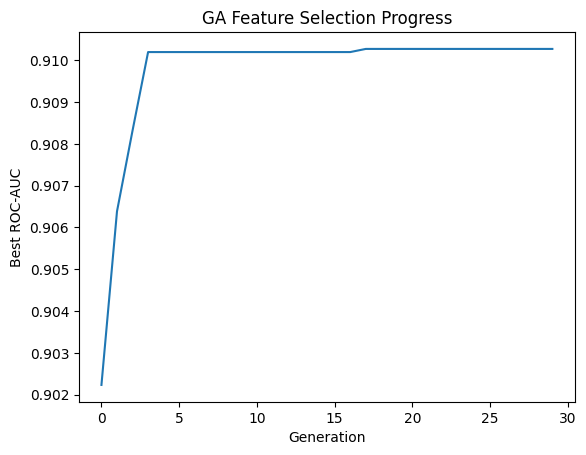

Best individual (feature mask): [1 1 1 1 0 1 0 1 1 1 1 1 1]
Selected features: ['age', 'sex', 'chest_pain_type', 'resting_blood_pressure', 'fasting_blood_sugar', 'Max_heart_rate', 'exercise_induced_angina', 'oldpeak', 'slope', 'vessels_colored_by_flourosopy', 'thalassemia']


In [22]:
best_individual, best_scores = run_genetic_algorithm(
    X, y, generations=30, pop_size=30, mutation_rate=0.1, elitism=0.1
)

print("Best individual (feature mask):", best_individual)
print("Selected features:", [f for f, bit in zip(feature_names, best_individual) if bit == 1])


# Final Evaluation (Test Performance)

In [23]:
from sklearn.metrics import roc_auc_score, roc_curve

def evaluate_final_model(X_train, X_test, y_train, y_test, best_individual, feature_names):
    # Selected features
    selected_features = [f for f, bit in zip(feature_names, best_individual) if bit == 1]
    print("Selected features:", selected_features)
    
    # Train on selected features
    X_train_sel = X_train[:, best_individual == 1]
    X_test_sel = X_test[:, best_individual == 1]
    
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', LogisticRegression(max_iter=500, solver='liblinear'))
    ])
    pipeline.fit(X_train_sel, y_train)
    y_pred_sel = pipeline.predict_proba(X_test_sel)[:, 1]
    
    auc_sel = roc_auc_score(y_test, y_pred_sel)
    print("ROC-AUC with GA-selected features:", auc_sel)
    
    # Train on all features
    pipeline.fit(X_train, y_train)
    y_pred_all = pipeline.predict_proba(X_test)[:, 1]
    auc_all = roc_auc_score(y_test, y_pred_all)
    print("ROC-AUC with all features:", auc_all)
    
    # Plot ROC curves
    fpr_sel, tpr_sel, _ = roc_curve(y_test, y_pred_sel)
    fpr_all, tpr_all, _ = roc_curve(y_test, y_pred_all)
    
    plt.figure(figsize=(6,6))
    plt.plot(fpr_sel, tpr_sel, label=f"GA-selected (AUC={auc_sel:.3f})")
    plt.plot(fpr_all, tpr_all, label=f"All features (AUC={auc_all:.3f})", linestyle="--")
    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve Comparison")
    plt.legend()
    plt.show()


Selected features: ['age', 'sex', 'chest_pain_type', 'resting_blood_pressure', 'fasting_blood_sugar', 'Max_heart_rate', 'exercise_induced_angina', 'oldpeak', 'slope', 'vessels_colored_by_flourosopy', 'thalassemia']
ROC-AUC with GA-selected features: 0.9273333333333332
ROC-AUC with all features: 0.9317142857142857


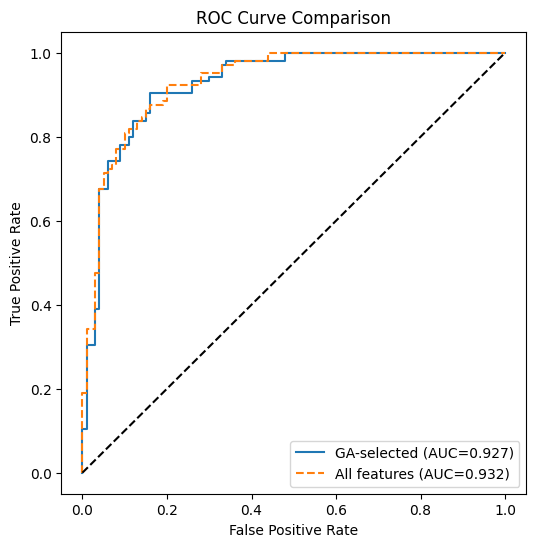

In [24]:
evaluate_final_model(X_train, X_test, y_train, y_test, best_individual, feature_names)


#  CNN1D + LSTM + adaptive TSK (neuro-fuzzy TSK layer)

In [34]:
# Cell A1
import os, random, math, time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, accuracy_score
import matplotlib.pyplot as plt

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
if torch.cuda.is_available(): 
    torch.cuda.manual_seed_all(RANDOM_STATE)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Use X,y from earlier cells. If they are numpy arrays, fine. Otherwise load df -> X,y.
# If X is (N, features) (static), reshape to (N, seq_len=1, features)
try:
    X  # see if X exists
except NameError:
    raise RuntimeError("X not found in workspace. Run earlier data-prep cells to create X and y.")

if X.ndim == 2:
    X_seq = X[:, None, :]   # (N, 1, features)
elif X.ndim == 3:
    X_seq = X
else:
    raise ValueError("Unexpected X shape: " + str(X.shape))

y_arr = np.array(y).astype(np.float32)
print("X_seq shape:", X_seq.shape, "y shape:", y_arr.shape)


Device: cuda
X_seq shape: (1025, 1, 13) y shape: (1025,)


In [35]:
# Cell A2
class SeqDataset(Dataset):
    def __init__(self, X_np, y_np, scaler=None):
        # X_np: (N, seq_len, feat)
        N, seq_len, feat = X_np.shape
        self.seq_len = seq_len
        self.feat = feat
        # flatten features across time for scaling
        X_flat = X_np.reshape(-1, feat)  # (N*seq_len, feat)
        if scaler is None:
            self.scaler = StandardScaler().fit(X_flat)
        else:
            self.scaler = scaler
        X_scaled = self.scaler.transform(X_flat).reshape(N, seq_len, feat)
        self.X = torch.tensor(X_scaled, dtype=torch.float32)
        self.y = torch.tensor(y_np, dtype=torch.float32)

    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

# Train-test split and dataloaders
X_train, X_test, y_train, y_test = train_test_split(
    X_seq, y_arr, test_size=0.2, stratify=y_arr, random_state=RANDOM_STATE
)
# build dataset with scaler fit on train
train_ds = SeqDataset(X_train, y_train, scaler=None)
test_ds = SeqDataset(X_test, y_test, scaler=train_ds.scaler)

# small val split from train for quick dev
val_size = max(1, int(0.1 * len(train_ds)))
train_size = len(train_ds) - val_size
train_ds, val_ds = random_split(train_ds, [train_size, val_size], generator=torch.Generator().manual_seed(RANDOM_STATE))

batch_size = 64
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

print("Train/Val/Test sizes:", len(train_ds), len(val_ds), len(test_ds))


Train/Val/Test sizes: 738 82 205


In [36]:
# Cell A3
class TSKFuzzyLayer(nn.Module):
    def __init__(self, feat_dim, R=8, out_dim=1, eps=1e-8):
        super().__init__()
        self.feat_dim = feat_dim
        self.R = R
        self.out_dim = out_dim
        self.eps = eps
        self.c = nn.Parameter(torch.randn(R, feat_dim) * 0.5)
        self.raw_sigma = nn.Parameter(torch.randn(R, feat_dim) * 0.1 - 1.0)
        self.a = nn.Parameter(torch.randn(R, feat_dim) * 0.1)
        self.b = nn.Parameter(torch.zeros(R, out_dim))

    def forward(self, x):
        # x: (batch, feat_dim)
        sigma = F.softplus(self.raw_sigma) + 1e-4
        x_exp = x.unsqueeze(1)      # (batch, 1, feat)
        c_exp = self.c.unsqueeze(0) # (1, R, feat)
        s_exp = sigma.unsqueeze(0)  # (1, R, feat)
        z = (x_exp - c_exp) / s_exp
        log_pdf = -0.5 * (z ** 2) - torch.log(s_exp + self.eps)
        log_w = torch.sum(log_pdf, dim=2)  # (batch, R)
        w = torch.exp(log_w)               # (batch, R)
        a_t = self.a.unsqueeze(0)          # (1, R, feat)
        y_r = torch.sum(a_t * x_exp, dim=2)  # (batch, R)
        y_r = y_r.unsqueeze(2) + self.b.unsqueeze(0)  # (batch, R, out_dim)
        w = w.unsqueeze(2)
        num = torch.sum(w * y_r, dim=1)
        den = torch.sum(w, dim=1) + self.eps
        out = num / den
        return out.squeeze(1)


In [37]:
# Cell A4
class CNN_LSTM_TSK(nn.Module):
    def __init__(self, in_features, seq_len, tsk_rules=6, lstm_hidden=32, out_dim=1):
        super().__init__()
        # small 1D conv backbone - if seq_len==1, conv acts like FC per feature-map
        self.conv = nn.Sequential(
            nn.Conv1d(in_channels=in_features, out_channels=32, kernel_size=1), # 1x1 conv
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Conv1d(32, 64, kernel_size=1),
            nn.BatchNorm1d(64),
            nn.ReLU()
        )
        # LSTM input size: channels after conv
        self.lstm_input_size = 64
        self.lstm = nn.LSTM(input_size=self.lstm_input_size, hidden_size=lstm_hidden,
                            num_layers=1, batch_first=True)
        self.fc = nn.Linear(lstm_hidden, lstm_hidden)
        self.tsk = TSKFuzzyLayer(feat_dim=lstm_hidden, R=tsk_rules, out_dim=out_dim)

    def forward(self, x):
        # x: (batch, seq_len, in_features)
        x = x.permute(0,2,1)   # -> (batch, in_features, seq_len)
        z = self.conv(x)       # (batch, channels, seq_len)
        z = z.permute(0,2,1)   # (batch, seq_len, channels)
        out, (hn, cn) = self.lstm(z)  # out: (batch, seq_len, lstm_hidden)
        last = out[:, -1, :]          # (batch, lstm_hidden)
        h = F.relu(self.fc(last))
        y = self.tsk(h)               # (batch,)
        return y  # raw score (logit-like). Use BCEWithLogitsLoss during training.


In [38]:
# Cell A5
def train_epoch(model, loader, opt, criterion):
    model.train()
    total_loss = 0.0
    for Xb, yb in loader:
        Xb, yb = Xb.to(device), yb.to(device).unsqueeze(1)
        opt.zero_grad()
        out = model(Xb)
        if out.dim()==1: out = out.unsqueeze(1)
        loss = criterion(out, yb)
        loss.backward()
        opt.step()
        total_loss += float(loss) * Xb.size(0)
    return total_loss / len(loader.dataset)

def eval_epoch(model, loader, criterion):
    model.eval()
    total_loss = 0.0
    ys, ps = [], []
    with torch.no_grad():
        for Xb, yb in loader:
            Xb, yb = Xb.to(device), yb.to(device).unsqueeze(1)
            out = model(Xb)
            if out.dim()==1: out = out.unsqueeze(1)
            loss = criterion(out, yb)
            total_loss += float(loss) * Xb.size(0)
            prob = torch.sigmoid(out).cpu().numpy().ravel()
            ys.append(yb.cpu().numpy().ravel())
            ps.append(prob)
    ys = np.concatenate(ys)
    ps = np.concatenate(ps)
    auc = roc_auc_score(ys, ps) if len(np.unique(ys))>1 else float('nan')
    return total_loss / len(loader.dataset), auc, ys, ps


In [39]:
# Cell A6
in_features = X_seq.shape[2]
seq_len = X_seq.shape[1]
model = CNN_LSTM_TSK(in_features=in_features, seq_len=seq_len, tsk_rules=6, lstm_hidden=32, out_dim=1).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()

n_epochs = 8   # small for quick dev; increase later
best_val_auc = -1.0
best_state = None
history = {'train_loss':[], 'val_loss':[], 'val_auc':[]}

for epoch in range(1, n_epochs+1):
    t0 = time.time()
    train_loss = train_epoch(model, train_loader, opt, criterion)
    val_loss, val_auc, _, _ = eval_epoch(model, val_loader, criterion)
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['val_auc'].append(val_auc)
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        best_state = {k:v.cpu().clone() for k,v in model.state_dict().items()}
    print(f"Epoch {epoch}/{n_epochs} | train_loss={train_loss:.4f} | val_loss={val_loss:.4f} | val_auc={val_auc:.4f} | time={(time.time()-t0):.1f}s")

# load best
if best_state is not None:
    model.load_state_dict(best_state)
print("Best val AUC:", best_val_auc)


Epoch 1/8 | train_loss=0.6765 | val_loss=0.6639 | val_auc=0.8907 | time=1.4s
Epoch 2/8 | train_loss=0.6280 | val_loss=0.6013 | val_auc=0.9058 | time=0.1s
Epoch 3/8 | train_loss=0.5604 | val_loss=0.5196 | val_auc=0.9191 | time=0.1s
Epoch 4/8 | train_loss=0.4804 | val_loss=0.4524 | val_auc=0.9239 | time=0.1s
Epoch 5/8 | train_loss=0.4195 | val_loss=0.3885 | val_auc=0.9324 | time=0.1s
Epoch 6/8 | train_loss=0.3872 | val_loss=0.3551 | val_auc=0.9420 | time=0.1s
Epoch 7/8 | train_loss=0.3536 | val_loss=0.3311 | val_auc=0.9457 | time=0.1s
Epoch 8/8 | train_loss=0.3305 | val_loss=0.2695 | val_auc=0.9692 | time=0.1s
Best val AUC: 0.9692028985507246


Test loss: 0.29988456179456013  Test AUC: 0.9564761904761905


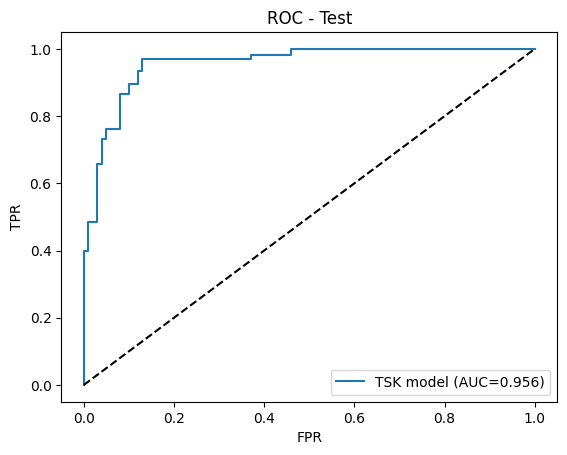

In [40]:
# Cell A7
test_loss, test_auc, ys_test, ps_test = eval_epoch(model, test_loader, criterion)
print("Test loss:", test_loss, " Test AUC:", test_auc)

# Simple ROC plot
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(ys_test, ps_test)
plt.figure()
plt.plot(fpr, tpr, label=f"TSK model (AUC={test_auc:.3f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.legend(); plt.title("ROC - Test")
plt.show()


#  Evolutionary NAS

In [41]:
# Cell B1
import copy, time, math, json
import torch.nn.functional as F

# Search space choices (tiny for speed)
CHANNEL_CHOICES = [8, 16, 32]    # filters
KERNEL_CHOICES  = [1, 3, 5]      # conv kernel sizes (1 works for seq_len=1)
OP_CHOICES = ['conv', 'skip']    # 'skip' means identity/skip-layer (helps variable depth)

# Genotype helpers
def random_gene():
    op = random.choice(OP_CHOICES)
    channels = random.choice(CHANNEL_CHOICES)
    kernel = random.choice(KERNEL_CHOICES)
    return (op, channels, kernel)

def random_genotype(min_layers=1, max_layers=4):
    L = random.randint(min_layers, max_layers)
    return [random_gene() for _ in range(L)]

def mutate_genotype(genotype, p_mut=0.2):
    # mutate each gene with probability p_mut
    new = copy.deepcopy(genotype)
    for i in range(len(new)):
        if random.random() < p_mut:
            # mutate one of the fields
            op, ch, k = new[i]
            choice = random.choice(['op','ch','k','swap'])
            if choice == 'op':
                new[i] = (random.choice(OP_CHOICES), ch, k)
            elif choice == 'ch':
                new[i] = (op, random.choice(CHANNEL_CHOICES), k)
            elif choice == 'k':
                new[i] = (op, ch, random.choice(KERNEL_CHOICES))
            elif choice == 'swap' and len(new) > 1:
                j = random.randrange(len(new))
                new[i], new[j] = new[j], new[i]
    # with small prob, add or remove a layer
    if random.random() < 0.05 and len(new) < 6:
        new.insert(random.randrange(len(new)+1), random_gene())
    if random.random() < 0.05 and len(new) > 1:
        idx = random.randrange(len(new))
        new.pop(idx)
    return new

def crossover_genotypes(g1, g2):
    # one-point crossover on lists
    if len(g1) == 0 or len(g2) == 0:
        return copy.deepcopy(g1), copy.deepcopy(g2)
    p1 = random.randint(0, len(g1)-1)
    p2 = random.randint(0, len(g2)-1)
    child1 = copy.deepcopy(g1[:p1] + g2[p2:])
    child2 = copy.deepcopy(g2[:p2] + g1[p1:])
    return child1, child2


In [42]:
# Cell B2
import torch.nn as nn

def build_model_from_genotype(genotype, in_channels, seq_len, num_classes=1):
    """
    Build small Conv1D-based classifier from genotype.
    - genotype: list of (op, channels, kernel)
    - in_channels: original feature channels
    """
    layers = []
    cur_in = in_channels
    for idx, (op, ch, k) in enumerate(genotype):
        if op == 'conv':
            layers.append(nn.Conv1d(in_channels=cur_in, out_channels=ch, kernel_size=k, padding=k//2))
            layers.append(nn.BatchNorm1d(ch))
            layers.append(nn.ReLU())
            # optional pooling to reduce seq length if >1
            if seq_len > 1:
                layers.append(nn.MaxPool1d(2))
            cur_in = ch
        elif op == 'skip':
            # implement as 1x1 conv if channels change, else identity
            if cur_in != ch:
                layers.append(nn.Conv1d(in_channels=cur_in, out_channels=ch, kernel_size=1))
                layers.append(nn.BatchNorm1d(ch))
                layers.append(nn.ReLU())
            # no pooling for skip
            cur_in = ch
    # head
    seq_pool = nn.AdaptiveAvgPool1d(1)
    flatten = nn.Flatten()
    fc = nn.Linear(cur_in, 64)
    clf = nn.Linear(64, num_classes)
    model = nn.Sequential(*layers, seq_pool, flatten, fc, nn.ReLU(), clf)
    return model.to(device)


In [43]:
# Cell B3
def evaluate_genotype(genotype, train_loader, val_loader, in_channels, seq_len,
                      epochs=2, lr=1e-3, verbose=False):
    """
    Build model, train for small number of epochs on train_loader, return val AUC.
    Keep model small & training short for speed.
    """
    model = build_model_from_genotype(genotype, in_channels, seq_len, num_classes=1)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    crit = nn.BCEWithLogitsLoss()
    # quick training
    model.train()
    for e in range(epochs):
        for Xb, yb in train_loader:
            Xb, yb = Xb.to(device), yb.to(device).unsqueeze(1)
            # shape to (batch, channels, seq)
            if Xb.dim() == 3:
                Xb = Xb.permute(0,2,1)
            opt.zero_grad()
            out = model(Xb)
            if out.dim()==1: out = out.unsqueeze(1)
            loss = crit(out, yb)
            loss.backward()
            opt.step()
    # validation
    model.eval()
    ys, ps = [], []
    with torch.no_grad():
        for Xv, yv in val_loader:
            Xv, yv = Xv.to(device), yv.to(device)
            if Xv.dim()==3: Xv = Xv.permute(0,2,1)
            out = torch.sigmoid(model(Xv)).squeeze(1).cpu().numpy()
            ys.append(yv.cpu().numpy())
            ps.append(out)
    ys = np.concatenate(ys)
    ps = np.concatenate(ps)
    if len(np.unique(ys)) <= 1:
        val_auc = 0.5
    else:
        try:
            val_auc = roc_auc_score(ys, ps)
        except:
            val_auc = 0.5
    if verbose:
        print(f"Genotype Eval - layers:{len(genotype)} val_auc={val_auc:.4f}")
    return val_auc, model  # return model optionally if you want to inspect


In [44]:
# Cell B4
def evolutionary_nas(train_loader, val_loader, in_channels, seq_len,
                     pop_size=8, generations=12, tournament_k=3,
                     p_mut=0.2, elitism=0.2, proxy_epochs=2):
    # initialize population
    pop = [random_genotype() for _ in range(pop_size)]
    fitness = np.zeros(pop_size, dtype=float)
    # evaluate initial pop
    for i, g in enumerate(pop):
        fitness[i], _ = evaluate_genotype(g, train_loader, val_loader, in_channels, seq_len, epochs=proxy_epochs)
    history = []
    n_elite = max(1, int(elitism * pop_size))
    for gen in range(1, generations+1):
        # new population
        new_pop = []
        # elitism: copy top n_elite
        elite_idx = np.argsort(fitness)[-n_elite:]
        elites = [copy.deepcopy(pop[i]) for i in elite_idx]
        new_pop.extend(elites)
        # fill rest
        while len(new_pop) < pop_size:
            # tournament selection
            idxs = np.random.choice(pop_size, tournament_k, replace=False)
            p1 = pop[idxs[np.argmax(fitness[idxs])]]
            idxs = np.random.choice(pop_size, tournament_k, replace=False)
            p2 = pop[idxs[np.argmax(fitness[idxs])]]
            # crossover
            c1, c2 = crossover_genotypes(p1, p2)
            # mutate
            c1 = mutate_genotype(c1, p_mut)
            c2 = mutate_genotype(c2, p_mut)
            new_pop.append(c1)
            if len(new_pop) < pop_size:
                new_pop.append(c2)
        # evaluate new population (but reuse elites' fitness)
        new_fitness = np.zeros(pop_size, dtype=float)
        for i, g in enumerate(new_pop):
            if i < n_elite:
                new_fitness[i] = fitness[elite_idx[i]]  # keep elite fitness
            else:
                new_fitness[i], _ = evaluate_genotype(g, train_loader, val_loader, in_channels, seq_len, epochs=proxy_epochs)
        pop = new_pop
        fitness = new_fitness
        best_idx = np.argmax(fitness)
        best_score = fitness[best_idx]
        history.append(best_score)
        print(f"[Gen {gen}/{generations}] Best proxy val AUC = {best_score:.4f} | genotype length = {len(pop[best_idx])}")
    # final best
    best_idx = np.argmax(fitness)
    best_genotype = pop[best_idx]
    best_score = fitness[best_idx]
    return best_genotype, best_score, history


[Gen 1/8] Best proxy val AUC = 0.9505 | genotype length = 2
[Gen 2/8] Best proxy val AUC = 0.9505 | genotype length = 2
[Gen 3/8] Best proxy val AUC = 0.9505 | genotype length = 2
[Gen 4/8] Best proxy val AUC = 0.9505 | genotype length = 2
[Gen 5/8] Best proxy val AUC = 0.9505 | genotype length = 2
[Gen 6/8] Best proxy val AUC = 0.9505 | genotype length = 2
[Gen 7/8] Best proxy val AUC = 0.9505 | genotype length = 2
[Gen 8/8] Best proxy val AUC = 0.9505 | genotype length = 2
Best genotype: [('skip', 8, 1), ('conv', 32, 3)]
Best proxy val AUC: 0.9504830917874396


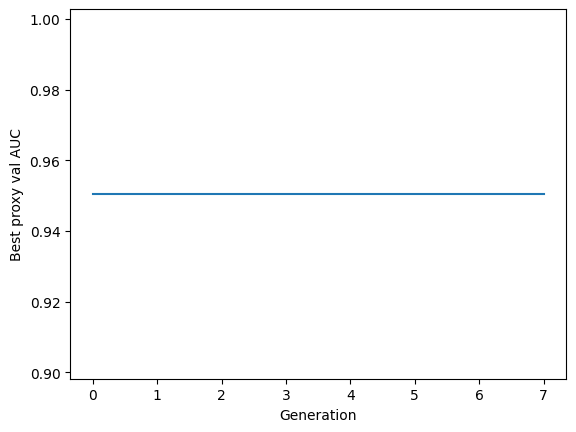

In [45]:
# Cell B5
in_channels = X_seq.shape[2]
seq_len = X_seq.shape[1]
# Use reduced loaders for proxy search speed: optionally use a smaller dataset or fewer batches
# (we already created train_loader, val_loader earlier)
best_genotype, best_score, history = evolutionary_nas(
    train_loader, val_loader, in_channels, seq_len,
    pop_size=6, generations=8, tournament_k=3, p_mut=0.25, elitism=0.2, proxy_epochs=2
)
print("Best genotype:", best_genotype)
print("Best proxy val AUC:", best_score)
plt.plot(history); plt.xlabel("Generation"); plt.ylabel("Best proxy val AUC"); plt.show()


In [46]:
# Cell B6
# Build model from best genotype and train a bit longer on train+val then test
best_model = build_model_from_genotype(best_genotype, in_channels, seq_len, num_classes=1)
# create combined train+val dataloader for final training
full_train_dataset = torch.utils.data.ConcatDataset([train_ds, val_ds])
full_train_loader = DataLoader(full_train_dataset, batch_size=64, shuffle=True)
opt = torch.optim.Adam(best_model.parameters(), lr=1e-3)
crit = nn.BCEWithLogitsLoss()

# train for more epochs
final_epochs = 8
for epoch in range(1, final_epochs+1):
    # train
    best_model.train()
    total_loss = 0.0
    for Xb, yb in full_train_loader:
        Xb, yb = Xb.to(device), yb.to(device).unsqueeze(1)
        if Xb.dim()==3: Xb = Xb.permute(0,2,1)
        opt.zero_grad()
        out = best_model(Xb)
        if out.dim()==1: out = out.unsqueeze(1)
        loss = crit(out, yb)
        loss.backward()
        opt.step()
        total_loss += float(loss) * Xb.size(0)
    avg_loss = total_loss / len(full_train_loader.dataset)
    # validate on test for quick monitor
    best_model.eval()
    ys, ps = [], []
    with torch.no_grad():
        for Xv, yv in test_loader:
            Xv, yv = Xv.to(device), yv.to(device)
            if Xv.dim()==3: Xv = Xv.permute(0,2,1)
            out = torch.sigmoid(best_model(Xv)).squeeze(1).cpu().numpy()
            ys.append(yv.cpu().numpy()); ps.append(out)
    ys = np.concatenate(ys); ps = np.concatenate(ps)
    test_auc = roc_auc_score(ys, ps) if len(np.unique(ys))>1 else float('nan')
    print(f"Epoch {epoch}/{final_epochs} | train_loss={avg_loss:.4f} | test_auc={test_auc:.4f}")

# Final test metrics
from sklearn.metrics import accuracy_score
preds = (ps >= 0.5).astype(int)
acc = accuracy_score(ys, preds)
auc = roc_auc_score(ys, ps)
print("Final Test Acc:", acc, "AUC:", auc)

# Save best genotype and model weights
torch.save(best_model.state_dict(), "/kaggle/working/best_evolved_model.pth")
with open("/kaggle/working/best_genotype.json", "w") as f:
    json.dump(best_genotype, f)
print("Saved best model & genotype to /kaggle/working/")


Epoch 1/8 | train_loss=0.6817 | test_auc=0.7894
Epoch 2/8 | train_loss=0.6221 | test_auc=0.8145
Epoch 3/8 | train_loss=0.5690 | test_auc=0.8392
Epoch 4/8 | train_loss=0.5118 | test_auc=0.8608
Epoch 5/8 | train_loss=0.4593 | test_auc=0.8766
Epoch 6/8 | train_loss=0.4270 | test_auc=0.8917
Epoch 7/8 | train_loss=0.4030 | test_auc=0.8989
Epoch 8/8 | train_loss=0.3818 | test_auc=0.9073
Final Test Acc: 0.8439024390243902 AUC: 0.9073333333333333
Saved best model & genotype to /kaggle/working/


# Fuzzy Logic

In [47]:

!pip install scikit-fuzzy

import skfuzzy as fuzz
from skfuzzy import control as ctrl


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 15.2 MB/s eta 0:00:00a 0:00:01


In [48]:
# Cell C2
# Define inputs
age = ctrl.Antecedent(np.arange(20, 90, 1), 'age')
chol = ctrl.Antecedent(np.arange(100, 400, 1), 'cholesterol')
thalach = ctrl.Antecedent(np.arange(60, 220, 1), 'max_hr')
oldpeak = ctrl.Antecedent(np.arange(0, 7, 0.1), 'oldpeak')

# Define output (severity 0-100)
severity = ctrl.Consequent(np.arange(0, 101, 1), 'severity')

# Membership functions (triangular / trapezoidal for interpretability)
age['young']   = fuzz.trapmf(age.universe, [20, 20, 35, 45])
age['middle']  = fuzz.trimf(age.universe, [35, 50, 65])
age['old']     = fuzz.trapmf(age.universe, [55, 65, 90, 90])

chol['low']    = fuzz.trapmf(chol.universe, [100, 100, 150, 200])
chol['normal'] = fuzz.trimf(chol.universe, [150, 220, 260])
chol['high']   = fuzz.trapmf(chol.universe, [240, 280, 400, 400])

thalach['low']  = fuzz.trapmf(thalach.universe, [60, 60, 90, 120])
thalach['med']  = fuzz.trimf(thalach.universe, [100, 140, 170])
thalach['high'] = fuzz.trapmf(thalach.universe, [150, 180, 220, 220])

oldpeak['low']  = fuzz.trapmf(oldpeak.universe, [0, 0, 1, 2])
oldpeak['med']  = fuzz.trimf(oldpeak.universe, [1.5, 2.5, 3.5])
oldpeak['high'] = fuzz.trapmf(oldpeak.universe, [3, 4, 7, 7])

# Severity output membership
severity['mild']     = fuzz.trapmf(severity.universe, [0, 0, 25, 40])
severity['moderate'] = fuzz.trimf(severity.universe, [30, 50, 70])
severity['severe']   = fuzz.trapmf(severity.universe, [60, 75, 100, 100])


In [49]:
# Cell C3
rule1 = ctrl.Rule(chol['high'] & thalach['low'], severity['severe'])
rule2 = ctrl.Rule(chol['normal'] & oldpeak['low'], severity['mild'])
rule3 = ctrl.Rule(age['old'] & oldpeak['high'], severity['severe'])
rule4 = ctrl.Rule(age['young'] & thalach['high'], severity['mild'])
rule5 = ctrl.Rule(chol['low'] & oldpeak['low'], severity['mild'])
rule6 = ctrl.Rule(oldpeak['med'] | (thalach['med'] & chol['normal']), severity['moderate'])
rule7 = ctrl.Rule(chol['high'] & oldpeak['high'], severity['severe'])
rule8 = ctrl.Rule(age['middle'] & thalach['med'], severity['moderate'])


In [50]:
# Cell C4
severity_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5, rule6, rule7, rule8])
severity_sim = ctrl.ControlSystemSimulation(severity_ctrl)


In [51]:
severity_sim.input['age'] = 60
severity_sim.input['cholesterol'] = 250
severity_sim.input['max_hr'] = 120
severity_sim.input['oldpeak'] = 3.5

severity_sim.compute()
sev_score = severity_sim.output['severity']
print("Fuzzy severity score:", sev_score)

if sev_score < 40:
    sev_label = "Mild"
elif sev_score < 70:
    sev_label = "Moderate"
else:
    sev_label = "Severe"
print("Severity label:", sev_label)


Fuzzy severity score: 69.97329006490264
Severity label: Moderate


In [52]:
# Cell C6 (integration)
# Suppose prob = model(X) gives predicted risk ∈ [0,1]
risk = ctrl.Antecedent(np.arange(0, 1.01, 0.01), 'risk')
risk['low']  = fuzz.trapmf(risk.universe, [0,0,0.2,0.4])
risk['med']  = fuzz.trimf(risk.universe, [0.3,0.5,0.7])
risk['high'] = fuzz.trapmf(risk.universe, [0.6,0.8,1,1])

# Add rules that include ML risk
rule9 = ctrl.Rule(risk['high'] & chol['high'], severity['severe'])
rule10 = ctrl.Rule(risk['low'] & oldpeak['low'], severity['mild'])

# Rebuild system with ML risk
severity_ctrl_ml = ctrl.ControlSystem([rule1,rule2,rule3,rule4,rule5,rule6,rule7,rule8,rule9,rule10])
severity_sim_ml = ctrl.ControlSystemSimulation(severity_ctrl_ml)

# Example with model probability
pred_prob = 0.82  # suppose from ML
severity_sim_ml.input['age'] = 60
severity_sim_ml.input['cholesterol'] = 250
severity_sim_ml.input['max_hr'] = 120
severity_sim_ml.input['oldpeak'] = 3.5
severity_sim_ml.input['risk'] = pred_prob
severity_sim_ml.compute()
print("Hybrid fuzzy severity score:", severity_sim_ml.output['severity'])


Hybrid fuzzy severity score: 69.97329006490264


In [58]:
# Build final fuzzy system including ML risk
risk = ctrl.Antecedent(np.arange(0, 1.01, 0.01), 'risk')
risk['low']  = fuzz.trapmf(risk.universe, [0,0,0.2,0.4])
risk['med']  = fuzz.trimf(risk.universe, [0.3,0.5,0.7])
risk['high'] = fuzz.trapmf(risk.universe, [0.6,0.8,1,1])

# Add ML-aware rules
rule9  = ctrl.Rule(risk['high'] & chol['high'], severity['severe'])
rule10 = ctrl.Rule(risk['low'] & oldpeak['low'], severity['mild'])

# Merge rules (clinical + ML)
severity_ctrl_full = ctrl.ControlSystem([
    rule1,rule2,rule3,rule4,rule5,rule6,rule7,rule8,rule9,rule10
])
severity_sim_full = ctrl.ControlSystemSimulation(severity_ctrl_full)


In [62]:
import numpy as np

# Ensure input is 2D (samples, features)
if len(X_train.shape) > 2:
    X_train_flat = X_train.reshape(X_train.shape[0], -1)
    X_test_flat  = X_test.reshape(X_test.shape[0], -1)
else:
    X_train_flat, X_test_flat = X_train, X_test


In [63]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(max_iter=500, solver='liblinear'))
])

pipeline.fit(X_train_flat, y_train)

# Predict probabilities
y_pred_probs = pipeline.predict_proba(X_test_flat)[:, 1]
print("Example ML risk probabilities:", y_pred_probs[:10])


Example ML risk probabilities: [0.02138828 0.19176293 0.03412062 0.49414982 0.55570887 0.0306833
 0.73134367 0.11101658 0.97815541 0.19176293]


In [65]:
results = []
for i in range(len(X_test_flat)):
    sev_score, sev_label = fuzzy_infer(X_test_flat[i], y_pred_probs[i])
    results.append((sev_score, sev_label))

import pandas as pd
df_results = pd.DataFrame({
    "TrueLabel": y_test,
    "ML_Prob": y_pred_probs,
    "Fuzzy_SeverityScore": [r[0] for r in results],
    "Fuzzy_SeverityLabel": [r[1] for r in results]
})

df_results.head(50)


,TrueLabel,ML_Prob,Fuzzy_SeverityScore,Fuzzy_SeverityLabel
0,0.0,0.021388,57.056707,Moderate
1,1.0,0.191763,33.780710,Mild
2,0.0,0.034121,50.000000,Moderate
3,1.0,0.494150,31.899591,Mild
4,0.0,0.555709,50.000000,Moderate
5,0.0,0.030683,72.797109,Severe
6,1.0,0.731344,17.845070,Mild
7,0.0,0.111017,27.725374,Mild
8,1.0,0.978155,36.872474,Mild
9,1.0,0.191763,33.780710,Mild


In [69]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns


In [70]:
import pandas as pd

df_results = pd.DataFrame({
    "TrueLabel": y_test,
    "ML_Prob": y_pred_probs,
    "Fuzzy_SeverityScore": [r[0] for r in results],
    "Fuzzy_SeverityLabel": [r[1] for r in results]
})

print(df_results.head())


   TrueLabel   ML_Prob  Fuzzy_SeverityScore Fuzzy_SeverityLabel
0        0.0  0.021388            57.056707            Moderate
1        1.0  0.191763            33.780710                Mild
2        0.0  0.034121            50.000000            Moderate
3        1.0  0.494150            31.899591                Mild
4        0.0  0.555709            50.000000            Moderate


In [72]:
df_results["Fuzzy_SeverityLabel"] = df_results["Fuzzy_SeverityLabel"].str.lower()


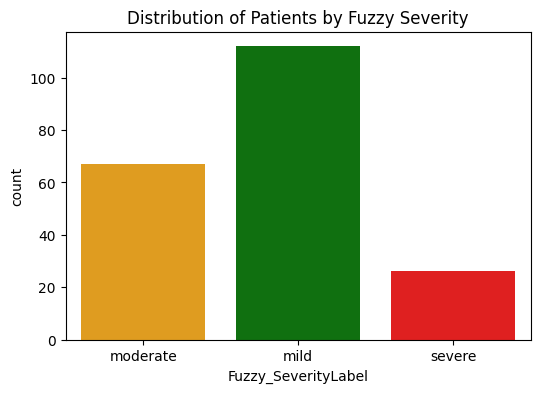

In [73]:
plt.figure(figsize=(6,4))
sns.countplot(x="Fuzzy_SeverityLabel", data=df_results,
              palette={"mild":"green", "moderate":"orange", "severe":"red"})
plt.title("Distribution of Patients by Fuzzy Severity")
plt.show()


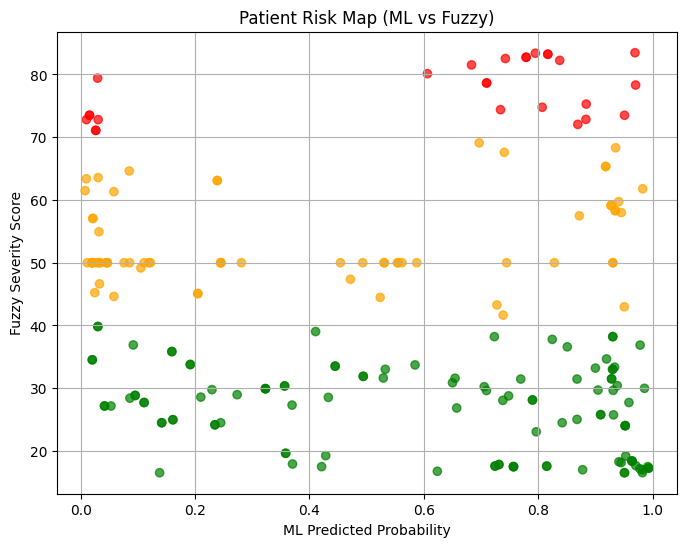

In [74]:
colors = {"mild":"green", "moderate":"orange", "severe":"red"}

plt.figure(figsize=(8,6))
plt.scatter(df_results["ML_Prob"], df_results["Fuzzy_SeverityScore"],
            c=df_results["Fuzzy_SeverityLabel"].map(colors), alpha=0.7)
plt.xlabel("ML Predicted Probability")
plt.ylabel("Fuzzy Severity Score")
plt.title("Patient Risk Map (ML vs Fuzzy)")
plt.grid(True)
plt.show()


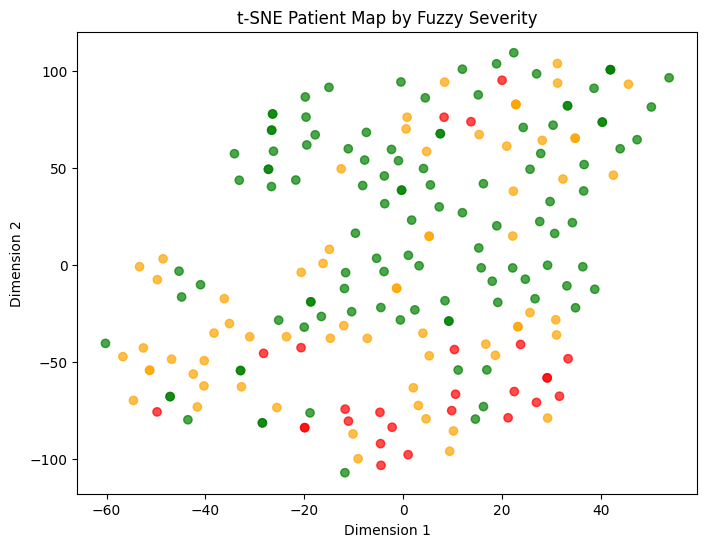

In [75]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2, random_state=42).fit_transform(X_test_flat)

plt.figure(figsize=(8,6))
plt.scatter(X_embedded[:,0], X_embedded[:,1],
            c=df_results["Fuzzy_SeverityLabel"].map(colors), alpha=0.7)
plt.title("t-SNE Patient Map by Fuzzy Severity")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()


# XAI 

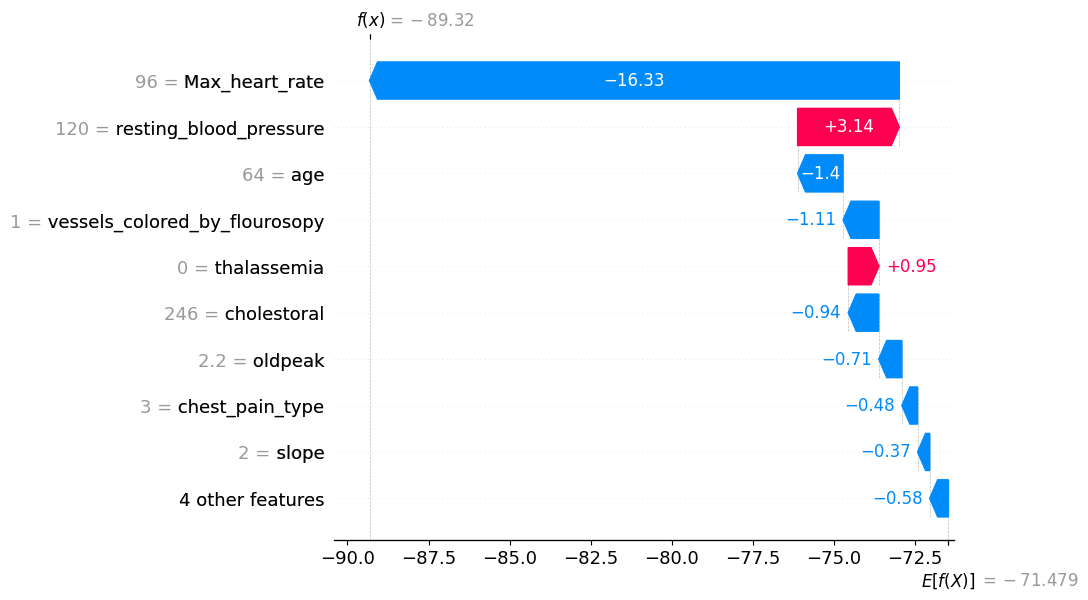

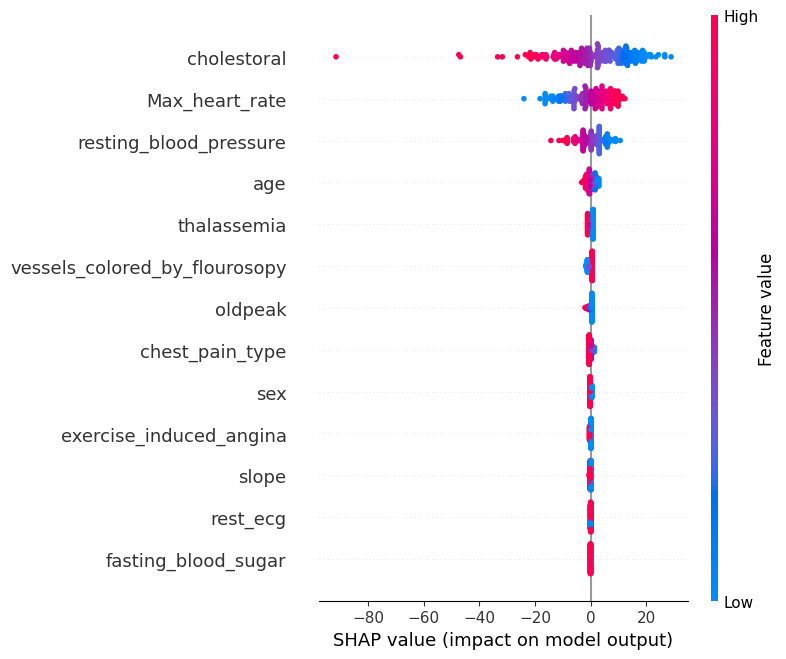

In [76]:
import shap

# Explain model predictions
explainer = shap.Explainer(pipeline['clf'], X_train_flat, feature_names=feature_names)
shap_values = explainer(X_test_flat)

# Plot explanation for first patient
shap.plots.waterfall(shap_values[0])

# Global feature importance
shap.summary_plot(shap_values, X_test_flat, feature_names=feature_names)


In [77]:
def explain_fuzzy(patient, ml_prob):
    sev_score, sev_label = fuzzy_infer(patient, ml_prob)
    print(f"Predicted Severity: {sev_label} ({sev_score:.2f})")
    print("Triggered rules:")
    for rule in severity_ctrl_full.rules:
        # crude check: if rule antecedents overlap with current input
        print(f" - {rule}")
    return sev_label


Patient 10:
 ML predicted prob = 0.683
 Fuzzy severity = Severe (score 81.52)


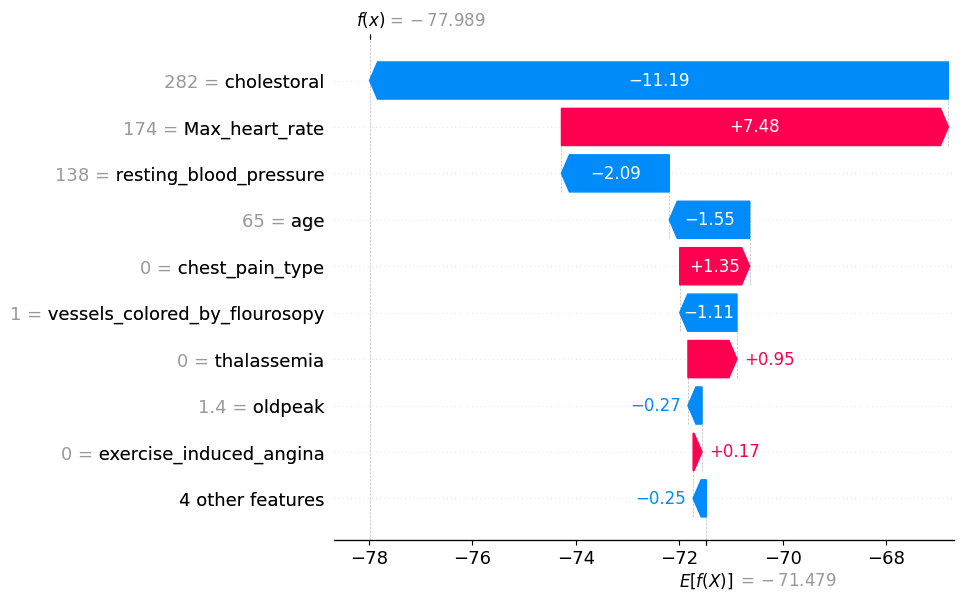

In [79]:
# Pick patient 10
i = 10
sev_score, sev_label = fuzzy_infer(X_test_flat[i], y_pred_probs[i])

print(f"Patient {i}:")
print(f" ML predicted prob = {y_pred_probs[i]:.3f}")
print(f" Fuzzy severity = {sev_label} (score {sev_score:.2f})")

# SHAP explanation
shap.plots.waterfall(shap_values[i])
